## $T_{Curie}$ Prediction.

- **Read in data and create feature and label tables.**
- **Visualizes feature correlations.**

- #### Deploy Machine Learning Models:####
    - Shallow Learning:
        - Support Vector Regression
        - Kernel Ridge Regression
        - Random Forest Regression
        - Gradient Boosting Regression  
    - Ensemble Learning:
        - Bagging
        - Stacking  
- #### Visualizes results & analysis####
- **Conclusion**

### Load in the Pickle File and Drop Duplicate Samples

In [2]:
import numpy as np
import pandas as pd
import pickle
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category = DeprecationWarning)

with open('feature.pkl', 'rb') as f:
    data = pickle.load(f)

data = data.drop_duplicates(subset = 'material_id')
data.head(5)

,Formula,Mag_atom,Near_Distance,SGR,Tc_avg,Tc_std,material_id,Tol_DOS,Fe_dDOS,Cr_dDOS,...,Co_dDOS,Coordnate_Number,Magnetic_moment,Bound_Length,lattice_a,lattice_b,lattice_c,lattice_alpha,lattice_beta,lattice_gamma
0,AlAu2Mn,Mn,4.495784914784067,225,216.50,16.500000,mp-5491,0.206274,0.000000,0.000000,...,0.000000,6.0,0.005000,4.528144,4.528144,4.528144,4.528144,60.000000,60.000000,60.000000
3,AlB2Fe2,Fe,2.6858372440369473,65,288.00,13.735599,mp-3805,0.132829,0.099305,0.000000,...,0.000000,4.0,-0.013000,2.785664,2.863114,2.915233,5.695537,104.828257,90.000000,90.000000
5,AlCCr2,Cr,2.7526898308246373,194,73.00,0.000000,mp-9956,0.158591,0.000000,0.130603,...,0.000000,4.5,0.000000,2.751682,2.843004,2.843004,12.707956,90.000000,90.000000,120.000000
8,AlCMn3,Mn,2.738058878110549,221,294.25,9.120718,mp-4593,0.127507,0.000000,0.000000,...,0.000000,8.0,-0.407333,2.691674,3.806601,3.806601,3.806601,90.000000,90.000000,90.000000
16,Al2Ce2Co15,Co,2.436418136336501,166,751.00,0.000000,mp-16484,1.120249,0.000000,0.000000,...,0.823275,8.0,1.180000,2.475784,6.325907,6.325907,6.325907,82.507456,82.507456,82.507456


### Only Keep Important Features in Table: 
- Density of state related: 
    - Tol_DOS, Fe_dDOS, Cr_dDOS, Mn_dDOS, Co_dDOS
- Crystal structure related: 
    - Coordnate_Number, Magnetic_moment,  Bound_Length

In [3]:
## get rid off nuisance features and drop NAN
tab = data.drop(['Formula', 'Mag_atom', 'Tc_std','material_id','SGR'],axis = 1)
tab = tab.dropna(axis=0)
print("The dimension of this tab is", tab.shape)

The dimension of this tab is (317, 16)


### Feature Scaling
- Apply standard feature **(StandardScaler)** scaling
    - z = (x - u)/s
    - x is the data point to be scale and u is the mean of data set and s is the standard deviation **(std).
    - The default behavior of is centering the data first and then scaling the data to unit std.

In [4]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler(copy = True, with_mean = True, with_std = True)

for i in range(tab.shape[1]):
    feature = np.array(tab.iloc[:,i]).reshape(tab.shape[0],1)
    scalar.fit(feature)
    if(tab.iloc[:,i].name == "Tc_avg"):
        mean_Tc_avg = scalar.mean_
        std_Tc_avg = np.sqrt(scalar.var_)
        print("The mean and std for Tc_avg are: {}, {}".format(mean_Tc_avg, std_Tc_avg))
    tab.iloc[:,i] = scalar.fit_transform(feature)

The mean and std for Tc_avg are: [383.51102451], [294.23471025]


### Compute Pair Correlation Between Features###
- High correlcation between 'Tol_DOS' and 'Fe_dDOS' and 'Co_dDOS'. 
- Shows that there is more samples contains Fe and Co element.

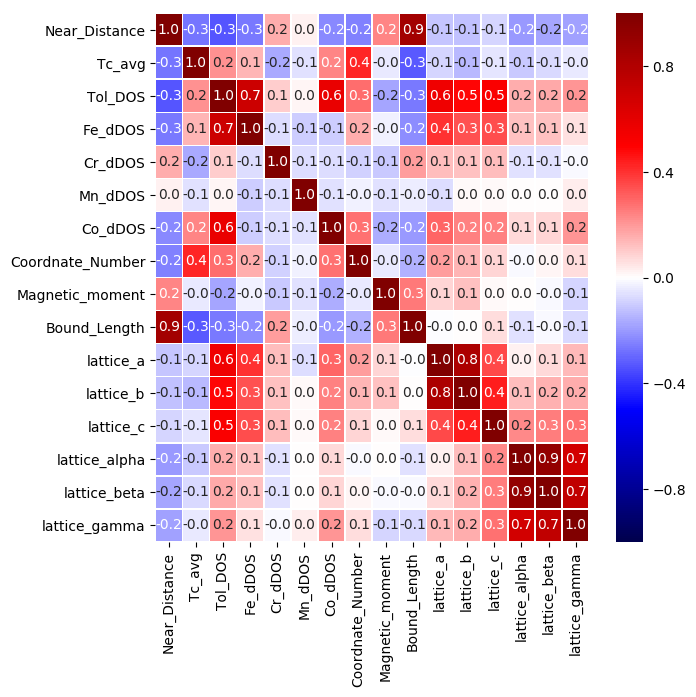

In [11]:
import seaborn as sn
import matplotlib.pyplot as plt

plt.figure(figsize = (7, 7), dpi = 100)
sn.heatmap(tab.corr(), annot = True, annot_kws = dict(fontsize = 10), fmt = '.1f', linewidths=.5, cmap = 'seismic', vmin = 1, vmax = -1)

### Shuffle the Orders of Sample, and Separate the Table to Input "X" and Lable "Y"

In [12]:
tab = tab.sample(frac = 1, random_state = 5).reset_index(drop = True)
X = tab.drop('Tc_avg', axis = 1)
Y = pd.DataFrame(tab['Tc_avg'])

### Import models: ###
- Support Vector Regression
- Kernel Ridge Regression 
- Random Forest 
- Gradient Boosting
- ridge (used for stacking)

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.linear_model import Ridge

### Apply Grid Search with 5 Folds Cross Validation
- Using R square and and explained_variance_score as metric for this regression model. 
- reference for Train/Test Split and Cross Validation.
    - https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6

### Define The Functions For Implementing Grid Search and Report Results
- **grid_search:** implement grid search and use R square as score.
- **report_grid_search:** function reports a list of R square values corresponding to each set of hyperparameters.

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, make_scorer
from tabulate import tabulate
from IPython.display import display, HTML

# enlarge the default display size of pandas column
pd.options.display.max_colwidth = 500

def grid_search(model, parameters, X, Y):
    scorer = make_scorer(r2_score, greater_is_better = True)
    grid_search = GridSearchCV(model, parameters, cv = 5, scoring = scorer)
    grid_search.fit(X, Y)
    return grid_search

def report_grid_search(search_result, parameters, show_number):
    print("best_socres = %.3f "% search_result.best_score_)
    print("best_parameters = %r" %search_result.best_params_)
    
    means = search_result.cv_results_['mean_test_score']
    stds = search_result.cv_results_['std_test_score']
    params = search_result.cv_results_['params']
    
    results = pd.DataFrame({'means': means, "stds": stds, "params": params})
    results = results.sort_values(by = ['means'], ascending = False)
    display(HTML(results.head(show_number).to_html()))

### Fine Tuned Parameters for Support Vector Regression (SVR) Model
- **Gamma**: Kernel coefficient for rbf, must be greater than 0.
- **C**: Penalty parameter C of the error term.
- **Epsilon**: a margin of tolerance (epsilon).
- **Url**: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html

In [16]:
parameters = [{'C': np.arange(3, 6, 0.1), 'epsilon': np.arange(0, 1, 0.05), 'gamma': np.arange(0.03, 0.07, 0.005) }]
model = SVR(kernel = 'rbf')
SVR_grid_search = grid_search(model, parameters, X, Y)
report_grid_search(SVR_grid_search, parameters, show_number = 5)

best_socres = 0.423 
best_parameters = {'C': 4.800000000000002, 'epsilon': 0.05, 'gamma': 0.03}


,means,stds,params
3249,0.422570,0.155662,"{'C': 4.800000000000002, 'epsilon': 0.05, 'gamma': 0.03}"
3429,0.422501,0.155231,"{'C': 4.900000000000002, 'epsilon': 0.05, 'gamma': 0.03}"
3069,0.422392,0.156211,"{'C': 4.700000000000001, 'epsilon': 0.05, 'gamma': 0.03}"
3609,0.422387,0.154951,"{'C': 5.000000000000002, 'epsilon': 0.05, 'gamma': 0.03}"
2889,0.422338,0.156596,"{'C': 4.600000000000001, 'epsilon': 0.05, 'gamma': 0.03}"


### Fine Tuned Parameters for Kernel Ridge Regression (KRR) Model
- **Alpha**: Penalty parameter to improve the conditioning of the problem and reduce the variance of the estimates.
- **Gamma**: Coefficient for the kernel.
-  **Url**: https://scikitlearn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html#sklearn.kernel_ridge.KernelRidge

In [17]:
parameters = [{'alpha': np.arange(0, 0.1, 0.01), 'gamma': np.arange(0.01, 0.03, 0.001) }]
model = KernelRidge(kernel = 'laplacian')
KRR_grid_search = grid_search(model, parameters, X, Y)
report_grid_search(KRR_grid_search, parameters, show_number = 5)

best_socres = 0.483 
best_parameters = {'alpha': 0.08, 'gamma': 0.028999999999999984}


,means,stds,params
179,0.482594,0.065638,"{'alpha': 0.08, 'gamma': 0.028999999999999984}"
199,0.482589,0.066666,"{'alpha': 0.09, 'gamma': 0.028999999999999984}"
178,0.482555,0.065729,"{'alpha': 0.08, 'gamma': 0.027999999999999983}"
177,0.482490,0.065827,"{'alpha': 0.08, 'gamma': 0.02699999999999999}"
198,0.482461,0.066745,"{'alpha': 0.09, 'gamma': 0.027999999999999983}"


### Fine Tuned Parameters for Random Forest Regression (RFR) Model 
- **n_estimators**: The number of trees in the forest.
- **max_depth**: The maximum depth of the tree. 
- **min_samples_split**: The minimum number of samples required to split an internal node.
- **url**: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html 

In [24]:
parameters = {'max_depth': [10, 100], 'min_samples_split': [2, 3, 4], 'n_estimators': [100, 500]}
model = RandomForestRegressor(random_state = 3)
RFR_grid_search = grid_search(model, parameters, X, Y)
report_grid_search(RFR_grid_search, parameters, show_number = 5)

best_socres = 0.485 
best_parameters = {'max_depth': 10, 'min_samples_split': 3, 'n_estimators': 100}


,means,stds,params
2,0.484601,0.116419,"{'max_depth': 10, 'min_samples_split': 3, 'n_estimators': 100}"
4,0.483934,0.114744,"{'max_depth': 10, 'min_samples_split': 4, 'n_estimators': 100}"
8,0.483496,0.113492,"{'max_depth': 100, 'min_samples_split': 3, 'n_estimators': 100}"
0,0.483103,0.115635,"{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}"
6,0.481790,0.119489,"{'max_depth': 100, 'min_samples_split': 2, 'n_estimators': 100}"


### Fine Tuned Parameters for Gradient Boosting Model
- **Url**: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

In [25]:
parameters = [{'n_estimators': [100], 'max_depth': [10, 20, 30], 'min_samples_split': [2, 6, 20, 40],
          'learning_rate': [0.1, 0.3]}]
model = GradientBoostingRegressor(loss = 'lad', random_state = 3)
GB_grid_search = grid_search(model, parameters, X, Y)
report_grid_search(GB_grid_search, parameters, show_number = 5)

best_socres = 0.463 
best_parameters = {'learning_rate': 0.1, 'max_depth': 10, 'min_samples_split': 6, 'n_estimators': 100}


,means,stds,params
1,0.463201,0.107322,"{'learning_rate': 0.1, 'max_depth': 10, 'min_samples_split': 6, 'n_estimators': 100}"
4,0.459322,0.138245,"{'learning_rate': 0.1, 'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}"
0,0.455384,0.114612,"{'learning_rate': 0.1, 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}"
11,0.450050,0.123977,"{'learning_rate': 0.1, 'max_depth': 30, 'min_samples_split': 40, 'n_estimators': 100}"
5,0.449216,0.121459,"{'learning_rate': 0.1, 'max_depth': 20, 'min_samples_split': 6, 'n_estimators': 100}"


## Ensemble Learning ##
- **Bagging:** Average the outputs of above four model to produce the prediction.
    - **url:** https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
- **Stacking:** combine above four models by training a linear regression model.

## Define Functions For Implementing Ensemble Learning ##
- **evalute_model_score:** return the R square score of a model.
- **split_test_train:** split the data set into train and test set by given indexes.
- **model_predictions:** trained models and produce models' predictions, return is a list with each item is a np.array prediction of a model.
- **avg_model_prediction:** average predictions of each model.
- **ensemble_bagging_R2:** 
    - Take a list of models as input, and return the R squre values of the ensemble model
    - Implementing this feature manually, since the 'kernel ridge regression' is not compatible with standard scikit-learn function, VotingRegression
- **stacking_model_input:** produce the input for the ridge regression in the stacking model.
- **ensemble_stacking_R2:** apply stacking method on models and return the corresponding R square value.

In [18]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.ensemble.voting import VotingRegressor


def evalute_model_score(model):
    scorer = make_scorer(r2_score, greater_is_better = True)
    scores = cross_val_score(model, X, Y, cv = 5, scoring = scorer) 
    return scores


def split_test_train(Data, indexes):
    X, Y = Data
    train_index, test_index = indexes
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    return (X_test, y_test, X_train, y_train)


def model_predictions(models, data):
    X_test, y_test, X_train, y_train = data
    y_preds = []
    for model in models:
        model.fit(X_train, y_train) 
        y_pred = model.predict(X_test)
        # to handle the dimensional issue for KRR
        y_pred = y_pred.reshape(len(y_pred))
        y_preds.append(y_pred)
    return y_preds


def avg_model_prediction(models, data):
    y_preds = model_predictions(models, data)
    y_preds = np.array([y_preds]).squeeze(axis = 0)
    y_preds = y_preds.mean(axis = 0)
    return y_preds


def ensemble_bagging_R2(models, Data, k_fold = 5):
    R_squares = []
    y_preds = np.array([])
    kf = KFold(n_splits = k_fold)
    for train_index, test_index in kf.split(X):
        split_data = split_test_train(Data, (train_index, test_index))
        y_pred = avg_model_prediction(models, split_data)
        y_test = split_data[1]
        y_preds = np.hstack((y_preds, y_pred))
        R_squares.append(r2_score(y_test, y_pred))
    return np.array([R_squares]).squeeze(axis=0), y_preds


def stacking_model_input(models, model_name, data):
    X_test, y_test, X_train, y_train = data  
    X_data = [X_test, X_train]
    stack_Xs = [pd.DataFrame(), pd.DataFrame()]
    for i, model in enumerate(models):
        model.fit(X_train, y_train)
        for j, x in enumerate(X_data):
            preds = model.predict(x)
            preds = preds.reshape(len(preds))
            stack_Xs[j][model_name[i]] = preds
    return stack_Xs[0], stack_Xs[1]


def ensemble_stacking_R2(models, model_name, Data, alpha, k_fold = 5):
    R_squares = []
    y_preds = np.array([])
    kf = KFold(n_splits = k_fold)
    for train_index, test_index in kf.split(X):
        split_data = split_test_train(Data, (train_index, test_index))
        y_test, y_train = split_data[1], split_data[3]
        stack_X_test, stack_X_train = stacking_model_input(models, model_name, split_data)
        reg = Ridge(alpha = alpha, normalize = True).fit(stack_X_train, y_train)
        y_pred = reg.predict(stack_X_test)
        y_pred = y_pred.reshape(len(y_pred))
        y_preds = np.hstack((y_preds, y_pred))
        R_squares.append(r2_score(y_test, y_pred))
    return np.array([R_squares]).squeeze(axis=0), y_preds

## Define Models with Optimized Hyperparameters ##

In [26]:
SVR_model = SVR(kernel = 'rbf', C = 5, epsilon = 0.2, gamma = 0.03)
KRR_model = KernelRidge(kernel = 'laplacian', alpha = 0.07, gamma = 0.03)
RFR_model = RandomForestRegressor(max_depth = 10, min_samples_split = 4, n_estimators = 100, random_state = 3)
GBR_model = GradientBoostingRegressor(learning_rate = 0.01, loss = 'ls', max_depth = 3, min_samples_split = 220, n_estimators = 1000, random_state = 3)
models = [SVR_model, KRR_model, RFR_model, GBR_model]

## Evaluate Perfomance of Each Model ##

In [20]:
model_name = ['Support Vector Regression', 'Kernel Ridge Regression'
              , 'Random Forest Regression', 'Gradient Boosting Regression']
for i, model in enumerate(models):
    scores = evalute_model_score(model)
    print('The R2 of %s model is %.4f with std %.4f' %(model_name[i] ,scores.mean(), scores.std()))

The R2 of Support Vector Regression model is 0.4067 with std 0.1543
The R2 of Kernel Ridge Regression model is 0.4820 with std 0.0645
The R2 of Random Forest Regression model is 0.4840 with std 0.1150
The R2 of Gradient Boosting Regression model is 0.4980 with std 0.0692


## Bagging ##
- Average the predctions of input models.
- We found drop **SVR** will give us the best result, even better than including all four models.
- The performance of bagging method is around 5% percent better than the best model, random forest regression.

In [21]:
Data = (X, Y)
models = [KRR_model, RFR_model, GBR_model]
bagging_cross_val_scores, bagging_cross_val_predict = ensemble_bagging_R2(models, Data, k_fold = 5)
print('the R2 of bagging method is %.5f with std %.5f' %(bagging_cross_val_scores.mean(), bagging_cross_val_scores.std())) 

the R2 of bagging method is 0.52041 with std 0.07839


## Stacking ##
- Similar to bagging method, but use a linear ridge regression to fine tune relative contributions between input models by optimizing R square value 
- Again, dropping **SVR** will give us the best result
- The reslt is 0.4% better than bagging result

In [22]:
Data = (X, Y)
models = [KRR_model, RFR_model, GBR_model]
model_name = ['Kernel Ridge Regression', 'Random Forest Regression', 'Gradient Boosting Regression']
stacking_cross_val_scores, stacking_cross_val_predict = ensemble_stacking_R2(models, model_name, Data, alpha = 0.42)
print('the R2 of stacking method is %.7f with std %.7f' %(stacking_cross_val_scores.mean()
                                                          , stacking_cross_val_scores.std())) 

the R2 of stacking method is 0.5222187 with std 0.0895648


## Collecting the Results of Ensemble Methods ##

In [27]:
ensemble_scores = [bagging_cross_val_scores, stacking_cross_val_scores]
ensemble_preds = [bagging_cross_val_predict, stacking_cross_val_predict]

## Summarize Results ## 

In [28]:
scores = []
Y_preds = []

models = [SVR_model, KRR_model, RFR_model, GBR_model]
model_name = ['Support Vector Reg.','Kernel Ridge Reg.'
              , 'Random Forest Reg.', 'Gradient Boosting Reg.']

for model in models:
    model.fit(X,Y)
    scores.append(cross_val_score(model, X, Y, cv = 5))
    Y_preds.append(cross_val_predict(model, X, Y, cv = 5))
    
scores = scores + ensemble_scores
Y_preds = Y_preds + ensemble_preds
model_name =  model_name + ['Bagging (Ensemble)', 'Stacking (Ensemble)']

## Visualizations ## 

In [32]:
Y_orig = Y * std_Tc_avg + mean_Tc_avg
Y_preds_orig = []
error = np.zeros((len(model_name), np.shape(Y)[0], ))
for i in range(len(model_name)):
    Y_preds_orig.append( (Y_preds[i] * std_Tc_avg + mean_Tc_avg).reshape(np.shape(Y_preds[i])[0],1))

## $R^2$ of Each Model

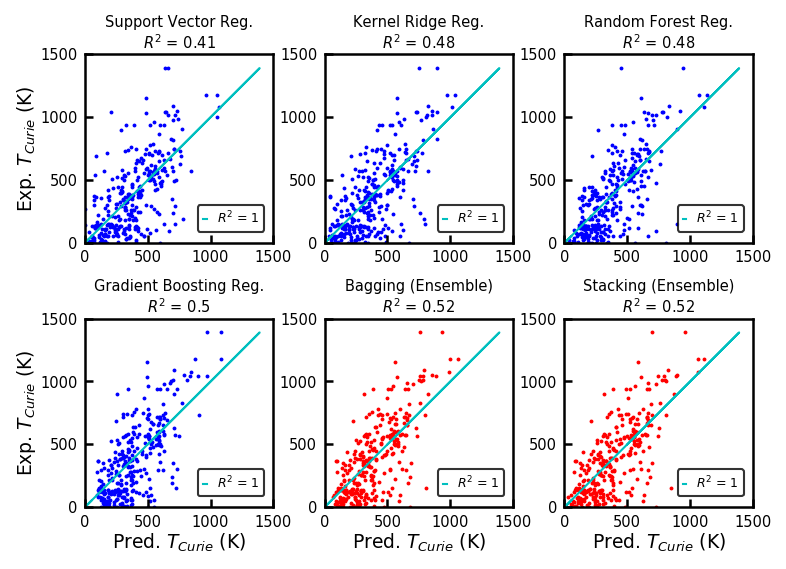

In [57]:
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from matplotlib.font_manager import FontProperties

fig = plt.figure(figsize = (6,4), dpi = 150)
for i in range(len(model_name)):
    ax = plt.subplot(2,3,i + 1)
    color = 'b'
    if(i >= 4): color = 'r'
    ax.scatter(Y_preds_orig[i], Y_orig, marker = '.', c = color, s = 3)
    ax.plot(Y_orig, Y_orig, 'c', linewidth = 1, label = '$R^2$ = 1')
    ax.set_xlim((0,1500))
    ax.set_ylim((0,1500))
    ax.set_yticks(np.arange(0, 1600, 500))
    if(i >= 3):ax.set_xlabel('Pred. $T_{Curie}$ (K)', fontsize = 9, labelpad = 1)
    if(i%3 == 0): ax.set_ylabel('Exp. $T_{Curie}$ (K)', fontsize = 9, labelpad = 1)
    ax.set_aspect('equal')
    for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(1.2)     
    ax.tick_params(labelsize = 7, which = "major", length = 4, width = 1.2, direction = 'in')
    ax.set_title(model_name[i]+'\n$R^2$ = '+str(np.round(np.mean(scores[i]), 2)) , fontsize = 7, pad = 3)
    ax.legend(loc = (0.6, 0.06), fontsize = 6, handlelength = 0.3, edgecolor = 'k')
plt.subplots_adjust(wspace = 0.1, hspace = 0.4)

In [42]:
def calculate_error(Y, Y_pred):
    Y = Y.to_numpy()
    error = np.divide( np.abs(Y_pred - Y), Y)
    return np.log10(error*100)

Y_orig = Y * std_Tc_avg + mean_Tc_avg
Y_preds_orig = []
error = np.zeros((len(model_name), np.shape(Y)[0], ))
for i in range(len(model_name)):
    Y_preds_orig.append( (Y_preds[i] * std_Tc_avg + mean_Tc_avg).reshape(np.shape(Y_preds[i])[0],1))
    error[i][:] = calculate_error(Y_orig, Y_preds_orig[i]).T

### Histograms of Error Percentage

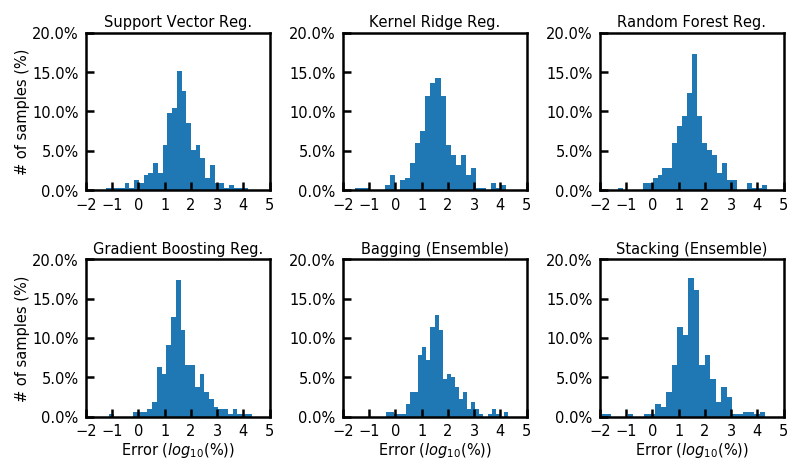

In [49]:
from matplotlib.ticker import PercentFormatter

fig = plt.figure(figsize = (6,4), dpi = 150)
for i in range(len(model_name)):
    ax = plt.subplot(2,3,i + 1)
    color = 'b'
    if(i >= 4): color = 'r'
    ax.hist(error[i][:], bins = 30, weights=np.ones(len(error[i][:])) / len(error[i][:]))
    #ax.plot(Y, Y, 'c', linewidth = 1, label = '$R^2$ = 1')
    ax.set_xlim((-2,5))
    ax.set_ylim((0,0.2))
    ax.set_xticks(np.arange(-2, 6, 1))
    if(i >= 3):ax.set_xlabel('Error ($log_{10}$(%))', fontsize = 7, labelpad = 1)
    if(i%3 == 0): ax.set_ylabel('# of samples (%)', fontsize = 7, labelpad = 1)
    ax.set_aspect(30)
    for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(1.2)     
    ax.tick_params(labelsize = 7, which = "major", length = 4, width = 1.2, direction = 'in')
    ax.set_title(model_name[i] , fontsize = 7, pad = 3)
    #ax.legend(loc = (0.54, 0.06), fontsize = 7, handlelength = 0.5, edgecolor = 'k')
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.subplots_adjust(wspace = 0.4, hspace = 0.)

## Predictive Power Analysis

In [58]:
print("% of samples with error < 50%.")
for i in range(len(model_name)):
    percent_smaller_than_50 = (error[i][:]<np.log10(50) ).sum()/len(error[i][:])
    print(str(model_name[i]) + "\t: {}%".format(np.round(percent_smaller_than_50*100,1)) )

% of samples with error < 50%.
Support Vector Reg.	: 60.6%
Kernel Ridge Reg.	: 60.9%
Random Forest Reg.	: 63.7%
Gradient Boosting Reg.	: 61.8%
Bagging (Ensemble)	: 63.1%
Stacking (Ensemble)	: 66.2%


In [59]:
print("% of samples with error < 330%.")
for i in range(len(model_name)):
    percent_smaller_than_50 = (error[i][:]<np.log10(330) ).sum()/len(error[i][:])
    print(str(model_name[i]) + "\t: {}%".format(np.round(percent_smaller_than_50*100,1)))

% of samples with error < 330%.
Support Vector Reg.	: 90.9%
Kernel Ridge Reg.	: 89.6%
Random Forest Reg.	: 90.2%
Gradient Boosting Reg.	: 89.6%
Bagging (Ensemble)	: 89.9%
Stacking (Ensemble)	: 90.2%


### Conclusion:
 
- #### We were able to:
    - Scrape data from online resources.
    - Create features from the data.
    - Build a pipeline of machine learning models.
 
- #### Model performance:
    - KRR gives better results than SVR.
    - Tree algorithms (RFR and GBR) perform better.
    - Ensemble learnings (Stacking and bagging) are 0.05 ~ 0.1 better in $R^2$ than shallow learnings.
 
- #### Physical insight:
    - Coordination number and bond length are important features, supporting mean-field theory.
    - For materials with Fe or Co, dDOS is important for the models, supporting Stoner theory.
    - Lattice constants are important in some clusters, indicating more features containing structural information might improve our models.
   
- #### Clustering:
    - Visulize high dimensional data on a two-dimensional plane by t-SNE.
    - K-means separates the data into 3 categories.
    - Coordination number is the most important feature among all clusters.
 
- #### Error analysis:
    - ~90% samples with error < 330% (half order).
    - Engineer features to improve predictive power.